In [3]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import pyro
from pyro.infer.autoguide import AutoMultivariateNormal, AutoIAFNormal, AutoNormalizingFlow, init_to_mean
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from utils.templates import get_NFW2_template

pyro.set_rng_seed(101)

In [4]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [39]:
nside = 128
r_outer = 25

In [40]:
from utils.templates import get_NFW2_template

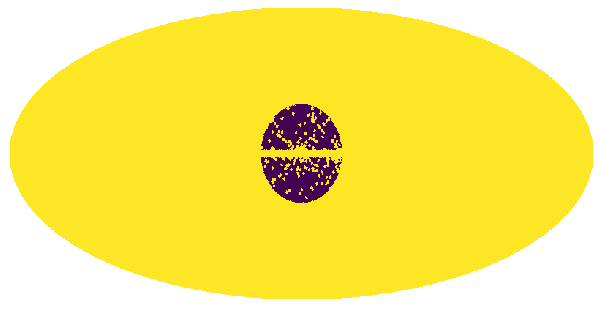

In [62]:
import sys
sys.path.append("../")

from utils import create_mask as cm

ps_mask = hp.ud_grade(np.load("../data/fermi_data/fermidata_pscmask.npy") > 0, nside_out=nside)
ps_mask = hp.ud_grade(np.load("../data/mask_3fgl_0p8deg.npy") > 0, nside_out=nside)

mask = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = r_outer, 
                          custom_mask=ps_mask
                              )

hp.mollview(mask,title='',cbar=False,min=0,max=1)

## Inference with pyro

In [86]:
data = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/fermidata_counts.npy'), nside_out=nside, power=-2))[~mask]
fermi_exp = (hp.ud_grade(np.load('../data/fermi_data/fermidata_counts.npy'), nside_out=nside, power=-2))

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = torch.Tensor(get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps))[~mask]

# temp_gce = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_gce.npy'), nside_out=nside, power=-2))[~mask]
temp_bub = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_bub.npy'), nside_out=nside, power=-2))[~mask]
temp_iso = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_iso.npy'), nside_out=nside, power=-2))[~mask]
temp_dif = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_dif.npy'), nside_out=nside, power=-2))[~mask]
temp_psc = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_psc.npy'), nside_out=nside, power=-2))[~mask]

temp_mO_pibrem = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy'), nside_out=nside, power=-2))[~mask]
temp_mO_ics = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/ModelO_r25_q1_ics.npy'), nside_out=nside, power=-2))[~mask]

temp_mA_pibrem = hp.ud_grade(np.load('../data/external/template_Fpi.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/external/template_Fic.npy'), nside_out=128, power=-2)
             
temp_mA_pibrem = torch.tensor(temp_mA_pibrem)[~mask]
temp_mA_ics = torch.tensor(temp_mA_ics)[~mask]

In [87]:
def model(data):
    A_bub = pyro.sample(r"$A_\mathrm{bub}$", dist.Uniform(0., 2.))
    A_iso = pyro.sample(r"$A_\mathrm{iso}$", dist.Uniform(0., 2.))
    A_psc = pyro.sample(r"$A_\mathrm{psc}$", dist.Uniform(0., 2.))
    A_dif = pyro.sample(r"$A_\mathrm{dif}$", dist.Uniform(0., 20.))
    A_ics = pyro.sample(r"$A_\mathrm{ics}$", dist.Uniform(0., 20.))
    A_gce = pyro.sample(r"$A_\mathrm{gce}$", dist.Uniform(0., 5.))
    mu = A_bub * temp_bub + A_iso * temp_iso + A_psc * temp_psc + A_dif * temp_mA_pibrem + A_ics * temp_mA_ics + A_gce * temp_gce
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Poisson(mu), obs=data)

In [88]:
from functools import partial
from pyro.distributions.transforms import block_autoregressive, iterated

# guide = AutoMultivariateNormal(model)
guide = AutoIAFNormal(model, num_transforms=4)

In [89]:
pyro.clear_param_store()
svi = SVI(model,
          guide,
          optim.Adam({"lr": .001}),
          loss=Trace_ELBO())

In [90]:
num_iterations = 4000

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))


[iteration 0001] loss: 8.4192
[iteration 0101] loss: 3.4866
[iteration 0201] loss: 2.8241
[iteration 0301] loss: 2.8364
[iteration 0401] loss: 2.7909
[iteration 0501] loss: 2.7802
[iteration 0601] loss: 2.7953
[iteration 0701] loss: 2.7931
[iteration 0801] loss: 2.7652
[iteration 0901] loss: 2.7848
[iteration 1001] loss: 2.7803
[iteration 1101] loss: 2.7639
[iteration 1201] loss: 2.7689
[iteration 1301] loss: 2.7705
[iteration 1401] loss: 2.7713
[iteration 1501] loss: 2.7640
[iteration 1601] loss: 2.7652
[iteration 1701] loss: 2.7700
[iteration 1801] loss: 2.7622
[iteration 1901] loss: 2.7667
[iteration 2001] loss: 2.7628
[iteration 2101] loss: 2.7635
[iteration 2201] loss: 2.7635
[iteration 2301] loss: 2.7640
[iteration 2401] loss: 2.7677
[iteration 2501] loss: 2.7621
[iteration 2601] loss: 2.7624
[iteration 2701] loss: 2.7627
[iteration 2801] loss: 2.7622
[iteration 2901] loss: 2.7627
[iteration 3001] loss: 2.7627
[iteration 3101] loss: 2.7623
[iteration 3201] loss: 2.7625
[iteration

In [91]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [92]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(data).items()
               if k != "obs"}


In [93]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: $A_\mathrm{bub}$
       mean      std       5%       25%     50%       75%      95%
0  0.370725  0.06765  0.26199  0.320614  0.3694  0.420684  0.48382 

Site: $A_\mathrm{iso}$
       mean       std        5%       25%       50%       75%       95%
0  1.489301  0.080171  1.360459  1.437098  1.499759  1.544493  1.605677 

Site: $A_\mathrm{psc}$
       mean       std        5%       25%       50%       75%       95%
0  0.803725  0.558575  0.071625  0.322915  0.703542  1.267742  1.787044 

Site: $A_\mathrm{dif}$
       mean       std       5%       25%       50%       75%      95%
0  7.686871  0.151427  7.47904  7.594582  7.670356  7.752547  7.97077 

Site: $A_\mathrm{ics}$
       mean       std        5%       25%       50%       75%      95%
0  3.892243  0.185029  3.535939  3.810013  3.907978  4.011936  4.14517 

Site: $A_\mathrm{gce}$
       mean      std     5%       25%       50%      75%       95%
0  1.283336  0.04636  1.209  1.253351  1.279705  1.31249  1.363955 



In [94]:
# nuts_kernel = NUTS(model)

# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=80)
# mcmc.run(data)

# hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [95]:
# for site, values in summary(hmc_samples).items():
#     print("Site: {}".format(site))
#     print(values, "\n")


/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

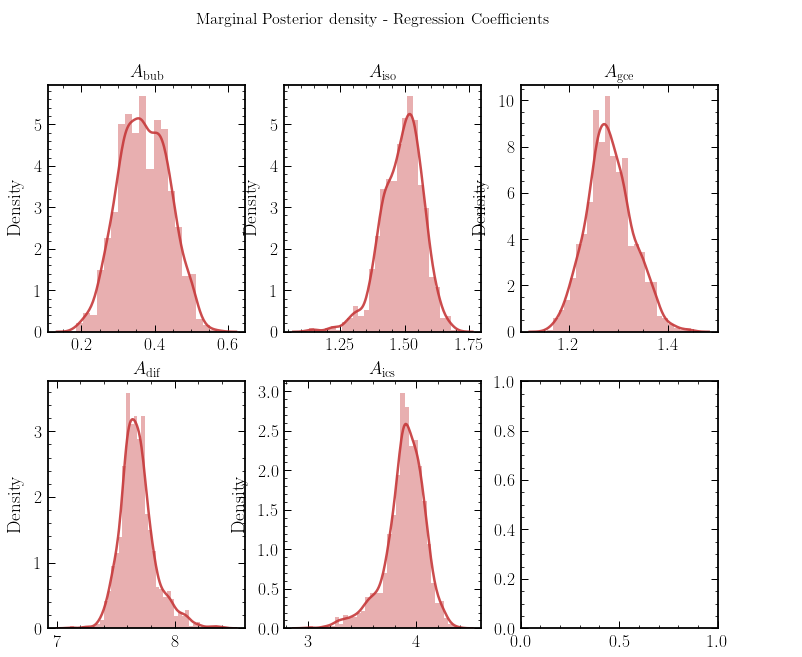

In [96]:
# sites = [r"$A_\mathrm{bub}$", r"$A_\mathrm{iso}$", r"$A_\mathrm{gce}$", r"$A_\mathrm{dif}$"]
sites = [r"$A_\mathrm{bub}$", r"$A_\mathrm{iso}$", r"$A_\mathrm{gce}$", r"$A_\mathrm{dif}$", r"$A_\mathrm{ics}$"]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    if i > 4: continue
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (Multivariate Normal)")
#     sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [61]:
torch.mean(temp_mA_ics) * 1.5, torch.mean(temp_mA_pibrem) * 10

(tensor(1.6273, dtype=torch.float64), tensor(10.2736, dtype=torch.float64))

In [57]:
counts_roi = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25)

mean_counts = np.mean(get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)[~counts_roi] * np.mean(svi_samples[r"$A_\mathrm{gce}$"]))
mean_counts

1.8479753322568608

In [135]:
ff = mean_counts / np.mean(np.load('../data/fermi_data/fermidata_counts.npy')[~counts_roi])
ff

0.09545733095785197